In [59]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import statsmodels.api
import scipy.stats
import pylab as pl
import os 
import sys
from getCitiBikeCSV import getCitiBikeCSV
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [41]:
datestring = '201603'
getCitiBikeCSV(datestring)

file in place, you can continue


In [42]:
bike_df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
bike_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72,W 52 St & 11 Ave,40.767272,-73.993929,427,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72,W 52 St & 11 Ave,40.767272,-73.993929,254,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72,W 52 St & 11 Ave,40.767272,-73.993929,493,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72,W 52 St & 11 Ave,40.767272,-73.993929,151,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1


In [43]:
bike_df['age'] = 2016 - bike_df['birth year']

In [44]:
bike_df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'age'],
      dtype='object')

In [45]:
bike_df.dropna(inplace = True)
bike_df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis = 1, inplace = True)
bike_df_2 = bike_df[bike_df.age < 100] # removes any people over the age of 100 as these are likely false

In [52]:
bike_df_2.describe()

,gender,age
count,826381.000000,826381.000000
mean,1.228374,39.195735
std,0.425016,11.688330
min,0.000000,16.000000
25%,1.000000,30.000000
50%,1.000000,37.000000
75%,1.000000,47.000000
max,2.000000,99.000000


In [53]:
grouped_bike_df = bike_df_2.groupby('age').count()

In [55]:
grouped_bike_df.columns = ['number_people'] # renames counted column

In [56]:
grouped_bike_df.head()

,number_people
age,
16.0,47
17.0,850
18.0,1930
19.0,2088
20.0,4367


826381

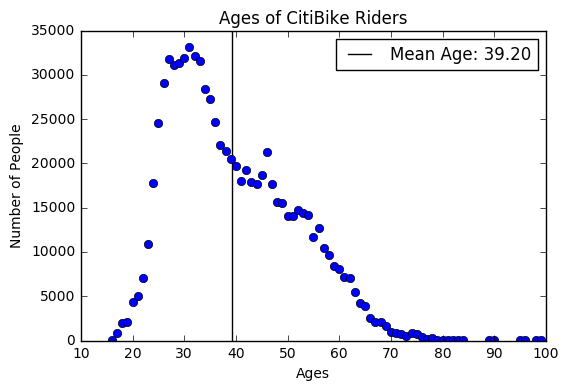

In [57]:
percent_age = np.array(grouped_bike_df.index) * np.array(grouped_bike_df.number_people) / grouped_bike_df.number_people.sum()
mean_age = percent_age.sum()
pl.plot(grouped_bike_df, 'o')
pl.title('Ages of CitiBike Riders')
pl.xlabel('Ages')
pl.ylabel('Number of People')
pl.vlines(x = mean_age, ymin= 0, ymax= 35000, label = "Mean Age: {0:.2f}".format(mean_age))
pl.legend()
grouped_bike_df.number_people.sum()

# Figure 1: Counts of Citibike riders plotted by age, with line designating the mean. The plot suggests that ages are skewed left.

Null Hypothesis: The ages of riders of Citibikes are normally distributed. 
$\alpha = 0.05$

In [61]:
mean = grouped_bike_df.number_people.mean()
std_dev = grouped_bike_df.number_people.std()
scipy.stats.kstest(grouped_bike_df.number_people, 'norm', args = (mean, std_dev))

KstestResult(statistic=0.16958745447783635, pvalue=0.023523435648696189)

In [62]:
scipy.stats.anderson(grouped_bike_df.number_people, 'norm')

AndersonResult(statistic=3.2186986949598975, critical_values=array([ 0.549,  0.625,  0.75 ,  0.875,  1.041]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

We can reject the null hypothesis that ages of Citibike riders are normally distributed using both the KS test (as the P-value of 0.02 is less than alpha = 0.05) and the Anderson test (as the statistic of 3.21 is greater than the critical values for significance levels as low as .01. 

Null Hypothesis: The ages of riders of Citibikes follow a logistic distribution. $\alpha = 0.05$

In [64]:
scipy.stats.kstest(grouped_bike_df.number_people, 'logistic', args = (mean, std_dev))

KstestResult(statistic=0.26520832028212782, pvalue=3.8055236970535589e-05)

In [66]:
scipy.stats.anderson(grouped_bike_df.number_people, 'logistic')

AndersonResult(statistic=3.0120218248530648, critical_values=array([ 0.425,  0.561,  0.658,  0.766,  0.903,  1.007]), significance_level=array([ 25. ,  10. ,   5. ,   2.5,   1. ,   0.5]))

We can reject the null hypothesis that ages of Citibike riders follow a logistic distribution using both the KS test (as the P-value of approximately 0.0 is less than alpha = 0.05) and the Anderson test (as the statistic of 3.01 is greater than the critical values for significance levels as low as .005. 